# NLP

Procesamiento de Lenguaje Natural

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Gestión de datos

In [8]:
#Leer archivo
inicio=pd.read_csv('toxic_train.csv', sep=';', encoding='latin')
inicio.head()

,id,text,HS
0,20430,@SomosRedSaime amigos SAIME mi nombre es walt...,0
1,22434,Preferan enfrentar los peligros de regresar a ...,0
2,23930,@srtaalegre_ Siiii jajjajajajjajajaja yo te ib...,0
3,20412,@anaisbernal Esta es la justicia en espaa para...,0
4,23531,Escucho Arabe y me dan ms ganas de estar en ch...,0


In [ ]:
inicio['text'] = inicio['text'].astype(str)

### Exploración

In [10]:
inicio['HS'].value_counts()

HS
0    975
1    756
Name: count, dtype: int64

### Preprocesamiento

In [ ]:
stop_words=set(stopwords.words('spanish'))

def limpiar_tweet(tweet):
    stemmer = SnowballStemmer('spanish')

    #Eliminar los @
    tweet=re.sub(r'@', '', tweet)

    #Eliminar las URL
    tweet=re.sub(r'httpsS?://[^\s\n\r]+','',tweet)

    #Eliminar todo lo que sean signos de puntuación, números
    tweet=re.sub(r'[^a-zA-ZñÑáéíóúÁÉÍÓÚ\s]','',tweet)

    #Eliminar los #
    tweet=re.sub(r'#', '', tweet)


    # Tokenización
    tokenizer= TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens=tokenizer.tokenize(tweet)

    #Stemming y stopwords
    tweet_limpio=[]

    for palabra in tweet_tokens:
        if palabra not in stop_words:
            palabra_stemmed=stemmer.stem(palabra)
            tweet_limpio.append(palabra_stemmed)
    
    return tweet_limpio
    

In [32]:
inicio['text'].head()

0    @SomosRedSaime  amigos SAIME mi nombre es walt...
1    Preferan enfrentar los peligros de regresar a ...
2    @srtaalegre_ Siiii jajjajajajjajajaja yo te ib...
3    @anaisbernal Esta es la justicia en espaa para...
4    Escucho Arabe y me dan ms ganas de estar en ch...
Name: text, dtype: object

In [31]:
first_tweets_cleaned=inicio['text'].head().apply(limpiar_tweet)
first_tweets_cleaned

0    [somosredsaim, amig, saim, nombr, walt, perez,...
1    [prefer, enfrent, peligr, regres, hog, ser, en...
2    [srtaalegr, siii, jajjajajajjajajaj, iba, ense...
3    [anaisbernal, justici, espa, indes, put, vergu...
4    [escuch, arab, dan, ms, gan, cheboli, muv, ort...
Name: text, dtype: object

In [ ]:
#Aplicarle limpieza
inicio['tweet_limpio']=inicio['text'].apply(lambda x: ' '.join(limpiar_tweet(x)))


In [34]:
inicio.head(5)

,id,text,HS,tweet_limpio
0,20430,@SomosRedSaime amigos SAIME mi nombre es walt...,0,somosredsaim amig saim nombr walt perez v wper...
1,22434,Preferan enfrentar los peligros de regresar a ...,0,prefer enfrent peligr regres hog ser encarcel ...
2,23930,@srtaalegre_ Siiii jajjajajajjajajaja yo te ib...,0,srtaalegr siii jajjajajajjajajaj iba ense vivs...
3,20412,@anaisbernal Esta es la justicia en espaa para...,0,anaisbernal justici espa indes put verguenz
4,23531,Escucho Arabe y me dan ms ganas de estar en ch...,0,escuch arab dan ms gan cheboli muv orto amig we


In [37]:
#WordCloud

all_words=' '.join([text for text in inicio['tweet_limpio'].dropna()])

<function matplotlib.pyplot.show(close=None, block=None)>

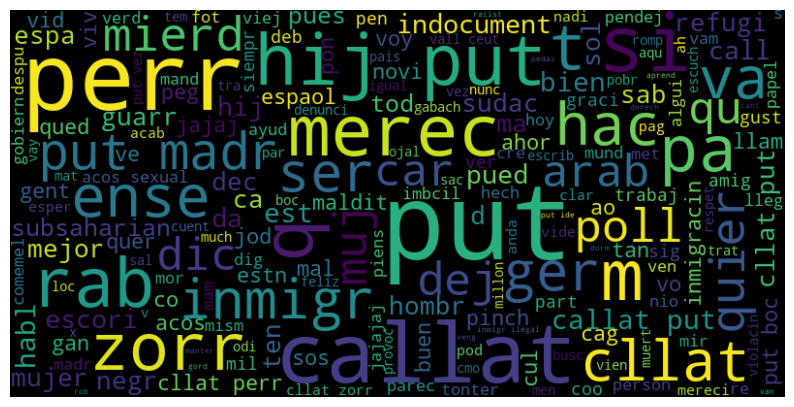

In [41]:
wordcloud=WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show


In [43]:
# Obtener número de palabras distintas
vocab_size=inicio['tweet_limpio'].dropna().apply(str.split).explode().nunique()
vocab_size

5512

In [ ]:
#Aplicar TF-IDF
vectorizer=TfidfVectorizer(max_features=5512)
X=vectorizer.fit_transform(inicio['tweet_limpio'])

In [47]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15733 stored elements and shape (1731, 5495)>

# Modelo

In [51]:
# Division train-test
X_train,X_test,y_train,y_test=train_test_split(X, inicio['HS'], test_size=0.8, random_state=42 )

### Regresión Logística

In [ ]:
#Entrenamiento de modelo
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [56]:
#Predicción y evaluación
y_prediction=model.predict(X_test)
reporte=classification_report(y_test,y_prediction)

print(reporte)

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       791
           1       0.74      0.48      0.58       594

    accuracy                           0.71      1385
   macro avg       0.72      0.68      0.68      1385
weighted avg       0.71      0.71      0.69      1385



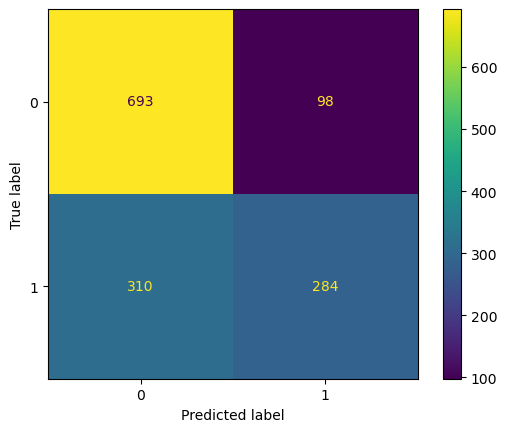

In [61]:
matriz= confusion_matrix(y_test,y_prediction)
disp = ConfusionMatrixDisplay(matriz)

disp.plot()
plt.show()